In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import scipy.io as sio
import scipy.signal as sig

In [2]:
example_subject_folder = "../data/MR-NIRP_Indoor/Subject1_motion_940"

example_nir_folder = os.path.join(example_subject_folder, "NIR")
if not os.path.isdir(example_nir_folder):
    example_nir_folder = os.path.join(example_subject_folder, "cam_flea3_1")
example_raw_folder = os.path.join(example_subject_folder, "RGB")
example_ppg_folder = os.path.join(example_subject_folder, "PulseOX")

example_nir_img_path = os.path.join(example_nir_folder, "Frame00000.pgm")
example_raw_img_path = os.path.join(example_raw_folder, "Frame00000.pgm")
example_ppg_mat_path = os.path.join(example_ppg_folder, "pulseOx.mat")

example_nir_time_path = os.path.join(example_subject_folder, "CameraTimeLog0.txt")
example_raw_time_path = os.path.join(example_subject_folder, "CameraTimeLog1.txt")

class:  ndarray
shape:  (640, 640)
strides:  (1280, 2)
itemsize:  2
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x5555f3f8e030
byteorder:  little
byteswap:  False
type: uint16
None
max pixel value: 62624, min pixel value: 0


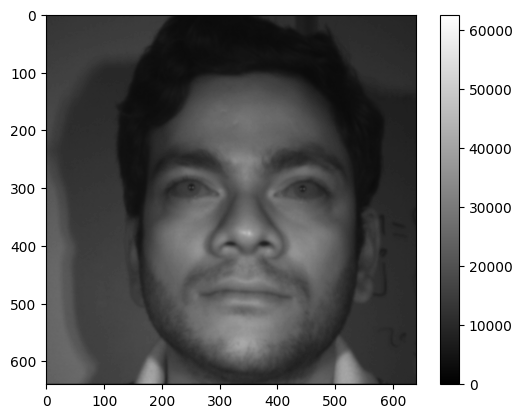

In [3]:
nir_img = cv2.imread(example_nir_img_path, cv2.IMREAD_UNCHANGED)
print(np.info(nir_img))
print(f"max pixel value: {nir_img.max()}, min pixel value: {nir_img.min()}")
plt.imshow(nir_img, cmap='gray')
plt.colorbar()


class:  ndarray
shape:  (640, 640)
strides:  (1280, 2)
itemsize:  2
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x5555f4580110
byteorder:  little
byteswap:  False
type: uint16
None
max pixel value: 65520, min pixel value: 0


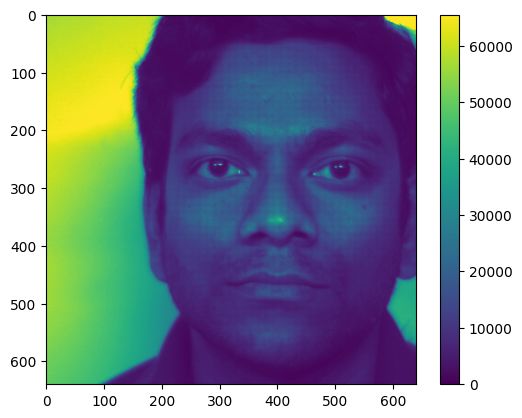

In [4]:
raw_img = cv2.imread(example_raw_img_path, cv2.IMREAD_UNCHANGED)  # Sensor format: RGGB
print(np.info(raw_img))
print(f"max pixel value: {raw_img.max()}, min pixel value: {raw_img.min()}")
plt.imshow(raw_img)
plt.colorbar()

class:  ndarray
shape:  (640, 640, 3)
strides:  (1920, 3, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x5555f485ce00
byteorder:  little
byteswap:  False
type: uint8
None
max pixel value: 255, min pixel value: 3


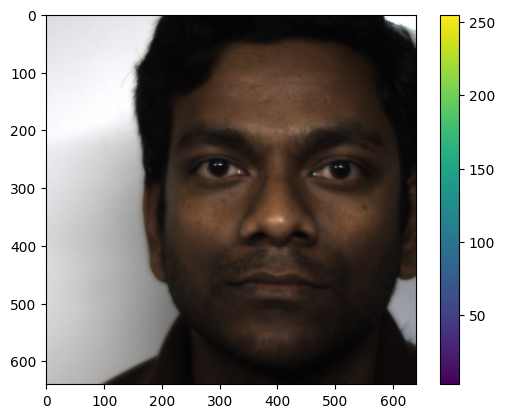

In [5]:
bayer_rg_img = cv2.normalize(raw_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  # Normalize raw image to 0-255
rgb_img = cv2.cvtColor(bayer_rg_img, cv2.COLOR_BAYER_RGGB2RGB)  # Demosaic RGGB raw image to RGB image
print(np.info(rgb_img))
print(f"max pixel value: {rgb_img.max()}, min pixel value: {rgb_img.min()}")
plt.imshow(rgb_img)
plt.colorbar()

In [6]:
nir_img_list = sorted(glob.glob(os.path.join(example_nir_folder, "*.pgm")))
raw_img_list = sorted(glob.glob(os.path.join(example_raw_folder, "*.pgm")))
nir_img_name_list = [os.path.basename(img_path) for img_path in nir_img_list]
raw_img_name_list = [os.path.basename(img_path) for img_path in raw_img_list]
unmatched_frame_list = list(set(nir_img_name_list) ^ set(raw_img_name_list))
print(f"Number of NIR frame: {len(nir_img_list)}")
print(f"Number of RGB frame: {len(raw_img_list)}")
print(f"Unmatched frame: {unmatched_frame_list}")

Number of NIR frame: 1967
Number of RGB frame: 1966
Unmatched frame: ['Frame01966.pgm']


In [7]:
ppg_mat = sio.loadmat(example_ppg_mat_path)
for key in ppg_mat.keys():
    if key.startswith("__"):
        continue
    print(f"Key: {key}, type: {type(ppg_mat[key])}, shape: {ppg_mat[key].shape}, dtype: {ppg_mat[key].dtype}")
    print(f"Value: {ppg_mat[key]}\n")

Key: pulseOxRecord, type: <class 'numpy.ndarray'>, shape: (1, 3910), dtype: object
Value: [[array([[43]]) array([[43]]) array([[44]]) ... array([[25]])
  array([[30]]) array([[37]])]]

Key: pulseOxTime, type: <class 'numpy.ndarray'>, shape: (1, 3910), dtype: float64
Value: [[1.51907692e+09 1.51907692e+09 1.51907692e+09 ... 1.51907698e+09
  1.51907698e+09 1.51907698e+09]]

Key: numPulseSample, type: <class 'numpy.ndarray'>, shape: (1, 1), dtype: int64
Value: [[3910]]



ppg_signal=

class:  ndarray
shape:  (3929,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x5555f4bfea20
byteorder:  little
byteswap:  False
type: int64

ppg_time=

class:  ndarray
shape:  (3929,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x5555f47c5810
byteorder:  little
byteswap:  False
type: float64


Text(0.5, 1.0, 'PPG Signal vs. Time')

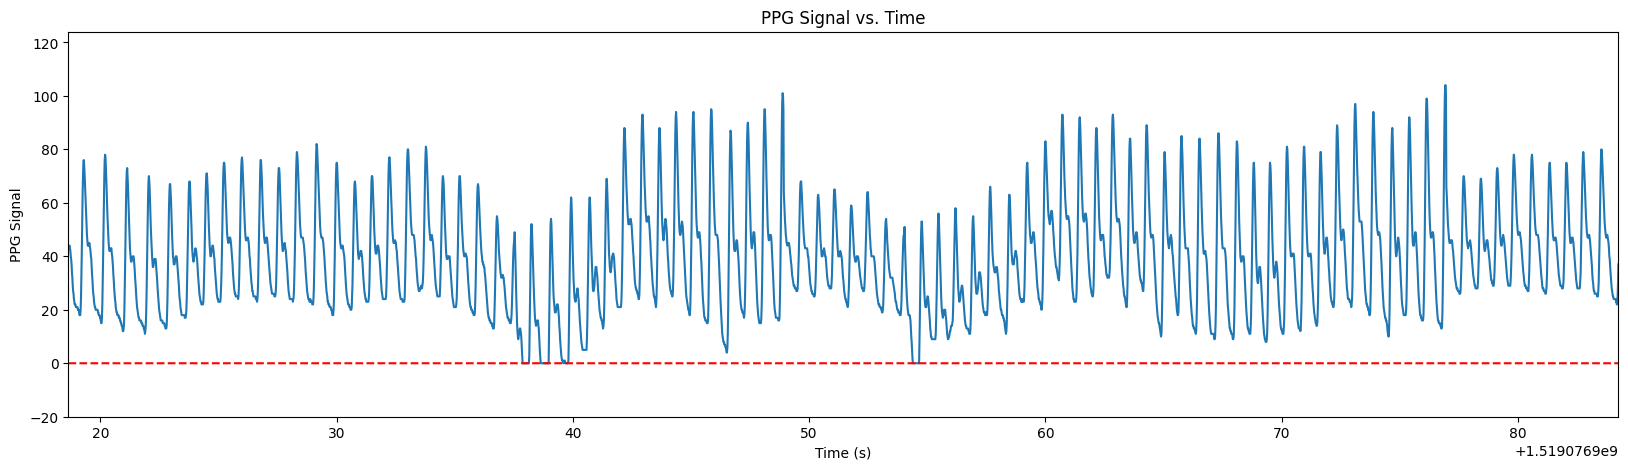

In [8]:
ppg_signal_corrupted = ppg_mat["pulseOxRecord"].squeeze()
ppg_time_corrupted = ppg_mat["pulseOxTime"][0]
ppg_signal, ppg_time = [], []
for idx, (value, time) in enumerate(zip(ppg_signal_corrupted, ppg_time_corrupted)):
    num_values = len(value[0]) if isinstance(value, np.ndarray) else 1
    if num_values > 1:  # Multiple values at a time step due to queued delayed ppg signal
        for sub_idx, sub_value in enumerate(value[0]):
            ppg_time.append(ppg_time_corrupted[idx-1] + ((sub_idx+1) / num_values) * (time - ppg_time_corrupted[idx-1]))
            ppg_signal.append(sub_value)
    else:
        ppg_time.append(time)
        ppg_signal.append(value.item())

ppg_signal = np.array(ppg_signal)
ppg_time = np.array(ppg_time)
print("ppg_signal=\n")
np.info(ppg_signal)
print('\nppg_time=\n')
np.info(ppg_time)

plt.figure(figsize=(20, 5))
plt.plot(ppg_time, ppg_signal)
plt.plot(ppg_time, np.zeros_like(ppg_time), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time")

ppg_signal_resampled=

class:  ndarray
shape:  (1967,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x5555f4793a10
byteorder:  little
byteswap:  False
type: float64

ppg_time_resampled=

class:  ndarray
shape:  (1967,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x5555f479be60
byteorder:  little
byteswap:  False
type: float64


Text(0.5, 1.0, 'PPG Signal vs. Time (Resampled)')

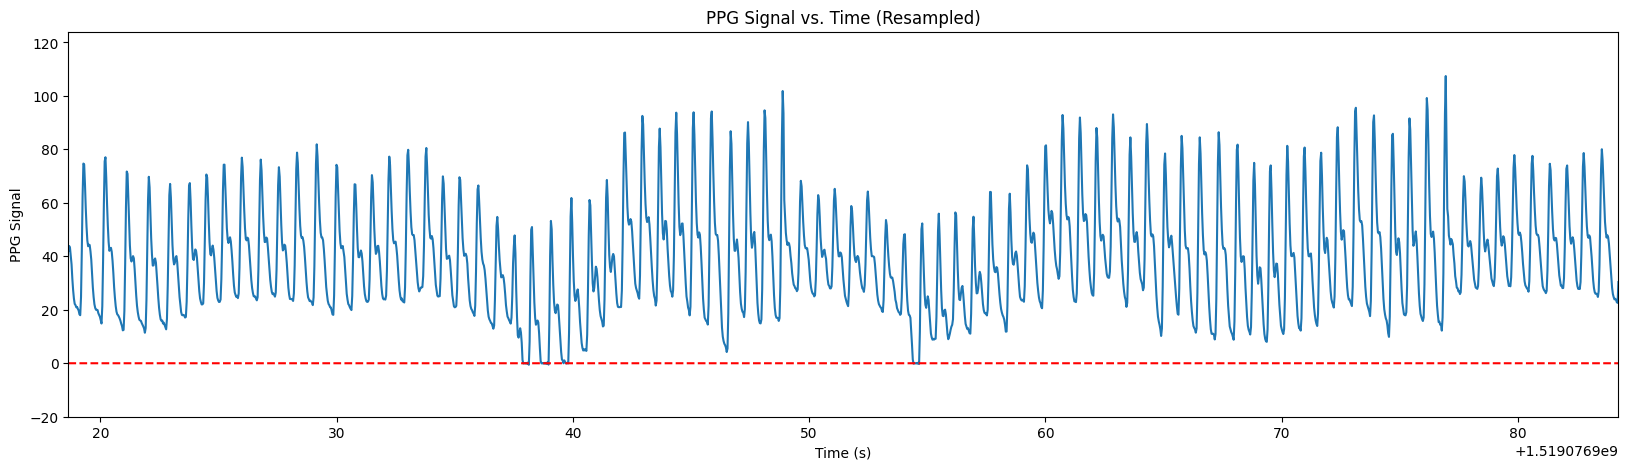

In [9]:
# Resample ppg_signal to the same size as nir_img_list
ppg_signal_resampled = sig.resample(ppg_signal, len(nir_img_list))
ppg_time_resampled = np.linspace(ppg_time[0], ppg_time[-1], len(nir_img_list))

print("ppg_signal_resampled=\n")
np.info(ppg_signal_resampled)
print('\nppg_time_resampled=\n')
np.info(ppg_time_resampled)

plt.figure(figsize=(20, 5))
plt.plot(ppg_time_resampled, ppg_signal_resampled)
plt.plot(ppg_time_resampled, np.zeros_like(ppg_time_resampled), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (Resampled)")

Text(0.5, 1.0, 'PPG Signal vs. Time (interpolated)')

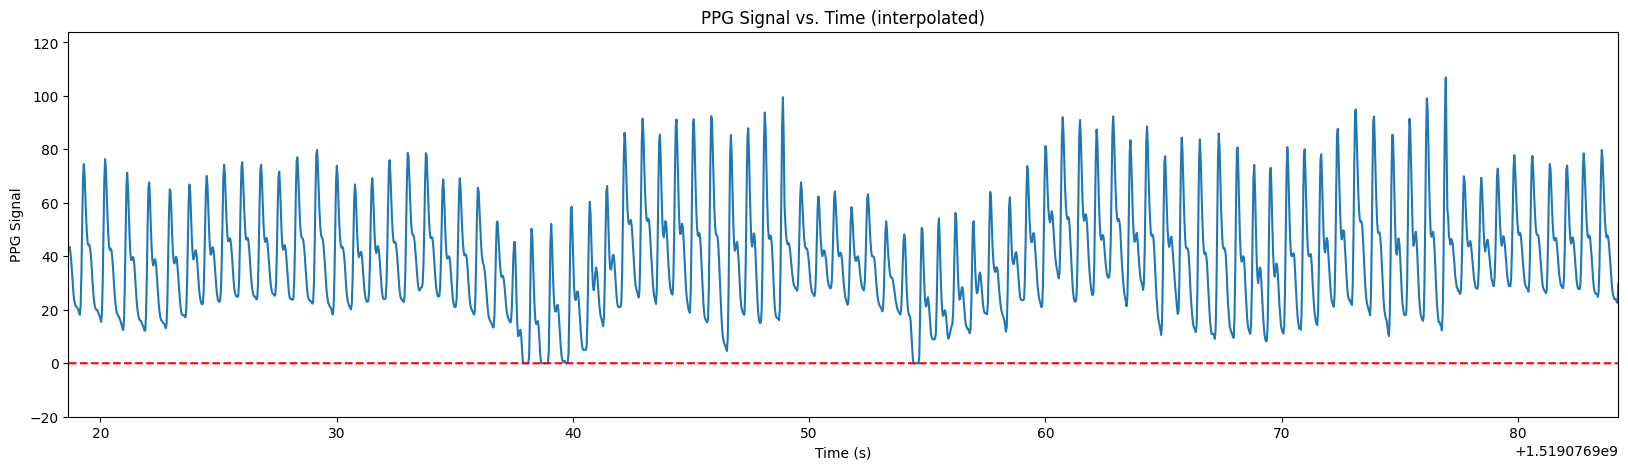

In [10]:
nir_time = np.loadtxt(example_nir_time_path)
# Align nir_time to ppg_time
ppg_signal_interpolated = []
for t in nir_time:
    # Interpolate ppg_signal to nir_time
    idx = np.searchsorted(ppg_time_resampled, t)
    if idx == 0:
        ppg_signal_interpolated.append(ppg_signal_resampled[idx])
    elif idx == len(ppg_time_resampled):
        ppg_signal_interpolated.append(ppg_signal_resampled[idx-1])
    else:
        ppg_signal_interpolated.append(ppg_signal_resampled[idx-1] + (t - ppg_time_resampled[idx-1]) * (ppg_signal_resampled[idx] - ppg_signal_resampled[idx-1]) / (ppg_time_resampled[idx] - ppg_time_resampled[idx-1]))

ppg_signal_interpolated = np.array(ppg_signal_interpolated)

plt.figure(figsize=(20, 5))
plt.plot(nir_time, ppg_signal_interpolated)
plt.plot(nir_time, np.zeros_like(nir_time), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (interpolated)")


Text(0.5, 1.0, 'PPG Signal vs. Time (differentiated)')

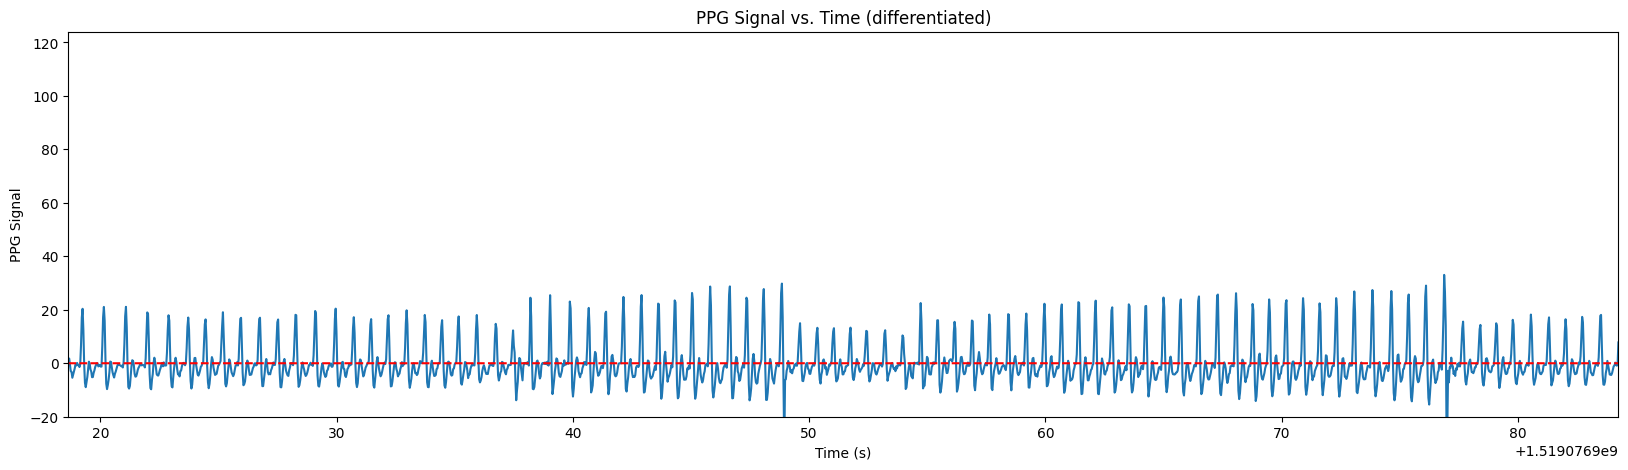

In [25]:
ppg_signal_diff = np.diff(ppg_signal_resampled)
ppg_signal_diff = np.concatenate(([ppg_signal_diff[0]], ppg_signal_diff))
plt.figure(figsize=(20, 5))
plt.plot(ppg_time_resampled, ppg_signal_diff)
plt.plot(ppg_time_resampled, np.zeros_like(ppg_time_resampled), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (differentiated)")


class:  ndarray
shape:  (1928,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x5555f92e3670
byteorder:  little
byteswap:  False
type: float64
MSE between ppg_signal_dl and 0: 61.39244542642055
MSE between ppg_signal_dl and average of ppg_signal_dl: 61.39181805568941


Text(0.5, 1.0, 'PPG Signal vs. Time (DL)')

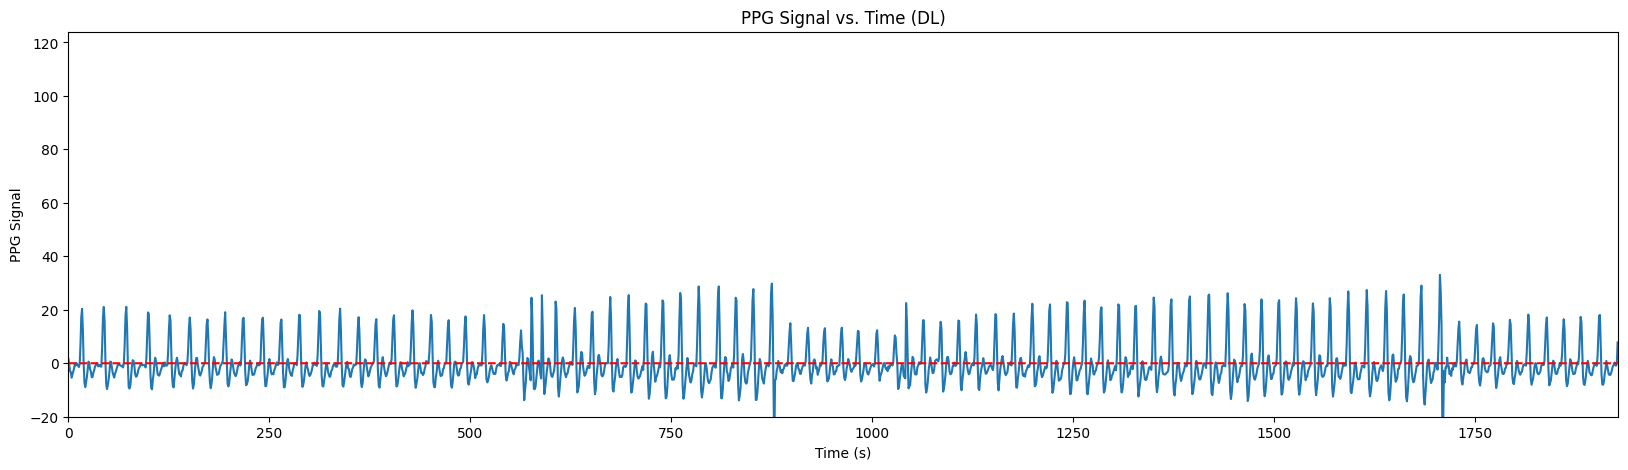

In [37]:
window_size = 2
ppg_signal_dl = []
for idx in range(0, len(ppg_signal_resampled) - window_size + 1):
    if np.any(ppg_signal_resampled[idx:idx+window_size] < 1):
        continue
    ppg_signal_dl.append(ppg_signal_resampled[idx+1] - ppg_signal_resampled[idx])
ppg_signal_dl = np.array(ppg_signal_dl)
np.info(ppg_signal_dl)

# Calculate the MSE between ppg_signal_interpolated and 0
mse = np.mean(np.square(ppg_signal_dl))
print(f"MSE between ppg_signal_dl and 0: {mse}")

# Calculate the MSE between ppg_signal_interpolated and average of ppg_signal_interpolated
mse = np.mean(np.square(ppg_signal_dl - np.mean(ppg_signal_dl)))
print(f"MSE between ppg_signal_dl and average of ppg_signal_dl: {mse}")

plt.figure(figsize=(20, 5))
plt.plot(ppg_signal_dl)
plt.plot(np.zeros_like(ppg_signal_dl), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(0, len(ppg_signal_dl))
plt.ylim(ppg_signal.min()-20, ppg_signal.max()+20)
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time (DL)")